In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

In [17]:
n_samples = 5000

def get_dataset_1():
    centers = [(-5, -5), (0, 0), (5, 5), (-5, 5), (5, -5), (0, 5), (5, 0), (-5, 0), (0, -5)]
#     centers = [(-5, -5), (0, 0), (5, 5)]
    # centers = [(-5, -5), (5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)
    X = (X - X.mean())/X.std()
    return X, y

In [18]:
X, y = get_dataset_1()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

Text(0.5, 1.0, 'Data')

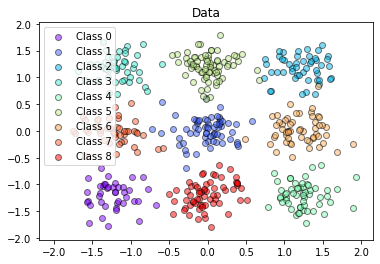

In [20]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

In [21]:
print(y_unique)

[0 1 2 3 4 5 6 7 8]


In [131]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, input_dim=2, compile_model_flag=True, lr=0.001, activation='tanh', kernel_initializer=initializers.glorot_uniform(), 
              reduce = 1,  output_size = 3):
    # Creo el modelo
    inp = Input(shape=(input_dim,))
    #bias_initializer = initializers.RandomUniform(-0.1, 0.1)
    bias_initializer = initializers.glorot_uniform()
    #bias_initializer = initializers.zeros()
    first_layer_out = Dense(784//reduce, activation=activation, name='hidden_1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(input_dim,))(inp)
    second_layer_out = Dense(784//reduce, activation=activation, name='hidden_2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(first_layer_out)
    output = Dense(output_size, name='Salida', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, activation='softmax')(second_layer_out)
    model = Model(inp, output)
    model_multiple_out = Model(inp, [first_layer_out, second_layer_out, output])
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model, model_multiple_out

model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.summary()

Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 784)               2352      
_________________________________________________________________
hidden_2 (Dense)             (None, 784)               615440    
_________________________________________________________________
Salida (Dense)               (None, 9)                 7065      
Total params: 624,857
Trainable params: 624,857
Non-trainable params: 0
_________________________________________________________________


In [34]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'
model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.save_weights(initial_weights)
epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/5
16/16 [==============================] - 0s 12ms/step - loss: 1.0128 - accuracy: 0.7060 - val_loss: 0.4614 - val_accuracy: 0.9042
Epoch 2/5
16/16 [==============================] - 0s 9ms/step - loss: 0.2935 - accuracy: 0.9480 - val_loss: 0.2154 - val_accuracy: 0.9540
Epoch 3/5
16/16 [==============================] - 0s 9ms/step - loss: 0.1595 - accuracy: 0.9560 - val_loss: 0.1291 - val_accuracy: 0.9727
Epoch 4/5
16/16 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.9580 - val_loss: 0.1102 - val_accuracy: 0.9718
Epoch 5/5
16/16 [==============================] - 0s 9ms/step - loss: 0.1076 - accuracy: 0.9640 - val_loss: 0.0945 - val_accuracy: 0.9727


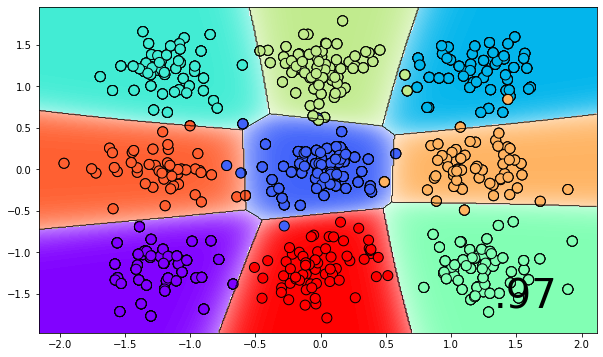

In [62]:
plt.figure(figsize=(10, 6))
model.load_weights(best_weights)
acc = model.evaluate(X_train, y_train, verbose=0)[1]
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

In [48]:
from LTH_helper import prune_and_initilize, plot_MC_boundaries_keras

In [49]:
pms = np.linspace(0.0001, 0.9999, 50)
accs = []
model.load_weights(best_weights)
for i, pm in enumerate(pms):
    pruned_model = prune_and_initilize(model, pm, initial_weights)
    acc = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
    accs.append(acc)
    print(i, pm, acc)

0 0.0001 0.10911110788583755
1 0.020504081632653062 0.10911110788583755
2 0.04090816326530613 0.10911110788583755
3 0.061312244897959195 0.10911110788583755
4 0.08171632653061225 0.10911110788583755
5 0.10212040816326531 0.10911110788583755
6 0.12252448979591839 0.10911110788583755
7 0.14292857142857143 0.10955555737018585
8 0.1633326530612245 0.1120000034570694
9 0.18373673469387755 0.14733333885669708
10 0.2041408163265306 0.20933333039283752
11 0.22454489795918367 0.312666654586792
12 0.24494897959183676 0.3946666717529297
13 0.2653530612244898 0.5099999904632568
14 0.2857571428571429 0.5879999995231628
15 0.30616122448979594 0.6684444546699524
16 0.326565306122449 0.7206666469573975
17 0.34696938775510205 0.7308889031410217
18 0.3673734693877551 0.7782222032546997
19 0.3877775510204082 0.7868888974189758
20 0.40818163265306123 0.8104444742202759
21 0.4285857142857143 0.8137778043746948
22 0.44898979591836735 0.8206666707992554
23 0.4693938775510204 0.8495555520057678
24 0.489797959

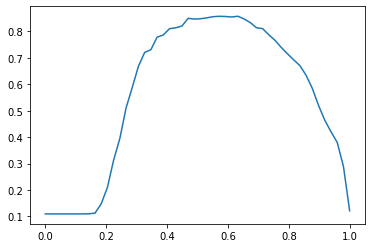

In [50]:
plt.plot(pms, accs)

In [38]:
model.load_weights(initial_weights)
model.evaluate(X_test, y_test, verbose=0)[1]

0.12088888883590698

0.6326265306122449 0.8575555682182312
141/141 [==============================] - 0s 850us/step - loss: 0.8305 - accuracy: 0.8576
0.8575555682182312


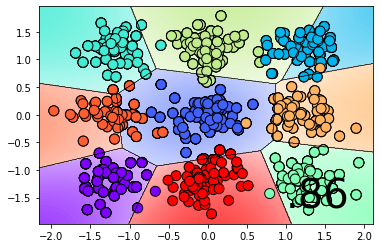

In [58]:
best = np.argmax(accs)
print(pms[best], accs[best])
pruned_model = prune_and_initilize(model, pms[best], initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

141/141 [==============================] - 0s 823us/step - loss: 1.4623 - accuracy: 0.1938
0.19377778470516205


/home/usuario/repos/prunning-fashion-MNIST/LTH_helper.py:276: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z_selected, (thres,), colors='k', linewidths=0.5)


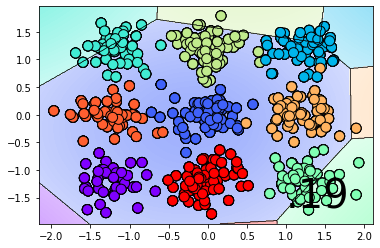

In [59]:
pruned_model = prune_and_initilize(model, 0.2, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=0.99)

141/141 [==============================] - 0s 786us/step - loss: 1.1731 - accuracy: 0.7116
0.711555540561676


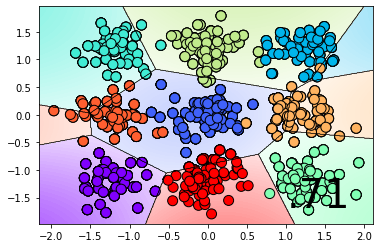

In [63]:
pruned_model = prune_and_initilize(model, 0.8, initial_weights)
acc = pruned_model.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=1-1/9)

# Delta weights

In [180]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'
model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=0.5), metrics=['accuracy'])
model.save_weights(initial_weights)
weights_0 = model.get_weights().copy()
epochs = 2
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/2
16/16 [==============================] - 0s 13ms/step - loss: 0.9510 - accuracy: 0.6960 - val_loss: 0.5207 - val_accuracy: 0.8051
Epoch 2/2
16/16 [==============================] - 0s 9ms/step - loss: 0.5268 - accuracy: 0.8340 - val_loss: 0.4063 - val_accuracy: 0.8551


In [181]:
weights_1 = model.get_weights()

In [182]:
mask = []
masked_weights = []
for i, layer_weights in enumerate(weights_0):
    mask.append(np.abs(weights_1[i]) > np.abs(layer_weights))
    masked_weights.append(mask[i]*weights_0[i])

In [183]:
total_w = 0
total_zeros = 0
for i in range(len(masked_weights)):
    with_zero = (masked_weights[i] == 0).sum()
    total_layer_w = (np.product(masked_weights[i].shape)).sum()
    sparcity = with_zero/total_layer_w
    total_w+=total_layer_w
    total_zeros+=with_zero
    print(sparcity, total_layer_w)
print('Network sparcity:')
print(total_zeros/total_w)

0.23533163265306123 1568
0.38010204081632654 784
0.48424972667638483 614656
0.40816326530612246 784
0.3486394557823129 7056
0.5555555555555556 9
Network sparcity:
0.48186865154747405


141/141 [==============================] - 0s 780us/step - loss: 0.4290 - accuracy: 0.9284
0.9284444451332092


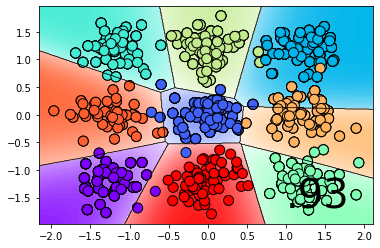

In [184]:
model_delta, _ = get_model(input_dim=2, output_size=len(y_unique))
model_delta.set_weights(masked_weights)
acc = model_delta.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, model_delta.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=1-1/9)

141/141 [==============================] - 0s 787us/step - loss: 2.2171 - accuracy: 0.1144
0.11444444209337234


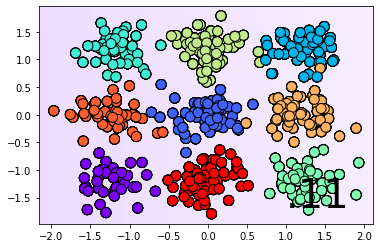

In [185]:
model_0, _ = get_model(input_dim=2, output_size=len(y_unique))
model_0.set_weights(weights_0)
acc = model_0.evaluate(X_test, y_test)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, model_0.predict, my_colors=colors, mesh_res = 500, alpha=1.0, almost_white=1-1/9)